In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report

/home/ryoyanagimoto/anaconda3/envs/hazumi1902/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def clean(df, flag):
    #共通で不要
    col_train = ['start(exchange)[ms]', 'end(system)[ms]', 'end(exchange)[ms]',\
    'kinectstart(exchange)[ms]', 'kinectend(system)[ms]',\
    'kinectend(exchange)[ms]', 'SS_ternary', 'TC_ternary', 'TS_ternary', 'SS',\
    'TC1', 'TC2', 'TC3', 'TC4', 'TC5', 'TS1', 'TS2', 'TS3', 'TS4', 'TS5',
    ]
    col_test1 = ['Unnamed: 972', 'Unnamed: 971', 'Unnamed: 970', '無言', '名詁E形容詁E感動詁E副詁Elabel']
    col_test2 = ['adjective', 'no_utterance', 'adverbs', 'noun', 'interjection']

    df_col = df.columns.values 

    if flag:
        df = df.drop(col_train, axis=1) 
        df = df.drop(col_test1, axis=1) 
        df = df.drop(col_test2, axis=1)
    else:
        df = df.drop(col_train, axis=1) 
        if set(df_col) >= set(col_test1):
            df = df.drop(col_test1, axis=1)
        else:
            df = df.drop(col_test2, axis=1)
    return df.values 


In [3]:
def make_target(df):
    df['TS'] = df.loc[:, 'TS1':'TS5'].sum(axis=1) >= 20
    df['TS'] = df['TS'].astype('int')
    return df['TS'].values

In [6]:
def louocv(files, testfile):
    #train_dfが空かどうか（空のtrain_dfにconcat()できないための対応）
    flag = True

    for file in files:
        if file == testfile:
            test_df = pd.read_csv(file)
        else:
            if flag:
                train_df = pd.read_csv(file)
                flag = False 
            else:
                tmp_df = pd.read_csv(file)
                train_df = pd.concat([train_df, tmp_df])


    return train_df, test_df

In [7]:
FILE_PATH = "/home/ryoyanagimoto/Hazumi1902/dumpfiles/*.csv"
files = glob.glob(FILE_PATH)

test_preds = []
test_ans = []

for testfile in files:
    train_df, test_df = louocv(files, testfile)

    #train_data = train_df.drop(col, axis=1).values 
    train_data = clean(train_df, True)
    train_target = make_target(train_df)
    # train_target = train_df['TS_ternary'].values 


    #test_data = test_df.drop(col, axis=1).values 
    test_data = clean(test_df, False)
    test_target = make_target(test_df)
    # test_target = test_df['TS_ternary'].values 

    x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_target, shuffle=True)

    scaler = StandardScaler()
    scaler.fit(x_train) 

    x_train = scaler.transform(x_train) 
    x_valid = scaler.transform(x_valid) 
    test_data = scaler.transform(test_data) 

    x_train = torch.from_numpy(x_train).to(torch.float)
    y_train = torch.from_numpy(y_train).to(torch.long)
    x_valid = torch.from_numpy(x_valid).to(torch.float)
    y_valid = torch.from_numpy(y_valid).to(torch.long)

    x_test = torch.from_numpy(test_data).to(torch.float)
    y_test = torch.from_numpy(test_target).to(torch.long)

    train_dataset = TensorDataset(x_train, y_train)
    valid_dataset = TensorDataset(x_valid, y_valid)

    batch_size = 100
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    class Net(nn.Module):    
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(1458, 50)
            self.fc2 = nn.Linear(50, 2)
    
        def forward(self, x):
            x = self.fc1(x)
            x = F.relu(x)
            x = self.fc2(x)
            x = F.softmax(x, dim=1)
            return x

    net = Net()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001)

    # エポック数
    num_epochs = 200

    # 学習時と検証時で分けるためディクショナリを用意
    dataloaders_dict = {
        'train': train_dataloader,
        'val': valid_dataloader
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        
        for phase in ['train', 'val']:
            
            if phase == 'train':
                # モデルを訓練モードに設定
                net.train()
            else:
                # モデルを推論モードに設定
                net.eval()
            
            # 損失和
            epoch_loss = 0.0
            # 正解数
            epoch_corrects = 0
            
            # DataLoaderからデータをバッチごとに取り出す
            for inputs, labels in dataloaders_dict[phase]:
                
                # optimizerの初期化
                optimizer.zero_grad()
                
                # 学習時のみ勾配を計算させる設定にする
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    
                    # 損失を計算
                    loss = criterion(outputs, labels)
                    
                    # ラベルを予測
                    _, preds = torch.max(outputs, 1)
                    
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        # 逆伝搬の計算
                        loss.backward()
                        # パラメータの更新
                        optimizer.step()
                    
                    # イテレーション結果の計算
                    # lossの合計を更新
                    # PyTorchの仕様上各バッチ内での平均のlossが計算される。
                    # データ数を掛けることで平均から合計に変換をしている。
                    # 損失和は「全データの損失/データ数」で計算されるため、
                    # 平均のままだと損失和を求めることができないため。
                    epoch_loss += loss.item() * inputs.size(0)
                    
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    pred = net(x_test)
    test_ans = test_ans + test_target.tolist()
    test_preds = test_preds + torch.argmax(pred, dim=1).tolist()

Epoch 1/200
-------------
train Loss: 0.7021 Acc: 0.4710
val Loss: 0.7041 Acc: 0.4606
Epoch 2/200
-------------
train Loss: 0.6980 Acc: 0.4979
val Loss: 0.6999 Acc: 0.4731
Epoch 3/200
-------------
train Loss: 0.6940 Acc: 0.5248
val Loss: 0.6957 Acc: 0.4928
Epoch 4/200
-------------
train Loss: 0.6901 Acc: 0.5469
val Loss: 0.6916 Acc: 0.5412
Epoch 5/200
-------------
train Loss: 0.6862 Acc: 0.5792
val Loss: 0.6876 Acc: 0.5789
Epoch 6/200
-------------
train Loss: 0.6824 Acc: 0.6073
val Loss: 0.6837 Acc: 0.6093
Epoch 7/200
-------------
train Loss: 0.6787 Acc: 0.6312
val Loss: 0.6798 Acc: 0.6308
Epoch 8/200
-------------
train Loss: 0.6751 Acc: 0.6515
val Loss: 0.6760 Acc: 0.6470
Epoch 9/200
-------------
train Loss: 0.6715 Acc: 0.6724
val Loss: 0.6724 Acc: 0.6667
Epoch 10/200
-------------
train Loss: 0.6681 Acc: 0.6946
val Loss: 0.6688 Acc: 0.6935
Epoch 11/200
-------------
train Loss: 0.6646 Acc: 0.7137
val Loss: 0.6653 Acc: 0.7168
Epoch 12/200
-------------
train Loss: 0.6613 Acc: 0

In [8]:
print(classification_report(test_ans, test_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       403
           1       0.83      1.00      0.91      1934

    accuracy                           0.83      2337
   macro avg       0.41      0.50      0.45      2337
weighted avg       0.68      0.83      0.75      2337



[[   0  403]
 [   1 1933]]


<AxesSubplot:>

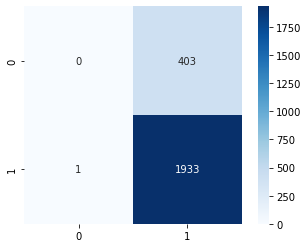

In [9]:
cm = confusion_matrix(test_ans, test_preds)
print(cm)

sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='d')

In [10]:
from sklearn.metrics import accuracy_score 
print(accuracy_score(test_ans, test_preds))

0.8271287976037656
